In [98]:
%reset
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition
import sympy as sym
import numpy as np
from IPython.display import display
from sympy import pprint

import dill
dill.load_session('simplified_bipod_thbodlocked_no_xy_final_mark.db')

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [99]:

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g] + [BLD] + [foot_angle] + [foot_length] +\
           [cg] + [lx_boom] + [ly_boom] +\
           [y_boomOffset] + [y_bodyOffset] + [x_footOffset] +\
           [COMR[link,leg] for leg in legs for link in links]+\
           [masses[base] for base in bases] +\
           [masses[link,leg] for leg in legs for link in links] +\
           [lengths[base] for base in bases] +\
           [lengths[link,leg] for leg in legs for link in links] +\
           [inertias['body']] + [inertias['boom','X']] + [inertias['boom','Y']] +\
           [inertias[link,leg] for leg in legs for link in links] +\
           [th[link,leg] for leg in legs for link in links] +\
           [dth[link,leg] for leg in legs for link in links] +\
           [ddth[link,leg] for leg in legs for link in links] +\
           [tau['left',leg] for leg in legs] + [tau['right',leg] for leg in legs] +\
           [lamda['x',leg] for leg in legs] + [lamda['y',leg] for leg in legs] +\
           [GRF['x',leg] for leg in legs] + [GRF['y',leg] for leg in legs]

lamb_EOMs = {}

DOFs = []

for leg in legs:
    for link in links:
        DOFs = DOFs + ['theta_{0}'.format(link+leg)]

# for dof_i,dof in enumerate(DOFs):
#     print(dof_i)
#    1


        
# print(len(DOFs))
# print(len(EOMs))     
for dof_i,dof in enumerate(DOFs):
    lamb_EOMs.update({dof: sym.lambdify(sym_list,EOMs[dof_i],modules = [func_map])})
# print(EOMs[0])

In [100]:
# PARAMETERS:

COMR_ = {'ULA': 41.14/174.5,
         'LLA': 132.2/300,
         'URA': 41.14/174.5,
         'LRA': 190.4/295.5,
         'ULB': 41.14/174.5,
         'LLB': 132.2/300,
         'URB': 41.14/174.5,         
         'LRB': 190.4/295.5}

masses_ = {'body': 5756.78/1000,
           'boom': 2470.66/1000,
           'ULA': 153.81/1000,
           'LLA': 346.45/1000,
           'URA': 153.81/1000,
           'LRA': 499.95/1000,
           'ULB': 153.81/1000,
           'LLB': 346.45/1000,
           'URB': 153.81/1000,
           'LRB': 499.95/1000}

lengths_ = {'body': 253/1000,
            'boom': None,
            'ULA': 174.5/1000,
            'LLA': 300.0/1000,
            'URA': 174.5/1000,
            'LRA': 295.5/1000,
            'ULB': 174.5/1000,
            'LLB': 300.0/1000,
            'URB': 174.5/1000,
            'LRB': 295.5/1000}

''' ****** '''
inertias_ = {'body': 32124078.52*1e-9, # body rotate about its center 
             'boom_X': 1947254622.19*1e-9,
             'boom_Y': 1947254622.19*1e-9,
             'ULA': 600933.68*1e-9, # rotates as pendulumn
             'LLA': 4659658.63*1e-9,
             'URA': 600933.68*1e-9,
             'LRA': 7369968.50*1e-9,
             'ULB': 600933.68*1e-9, # rotates as pendulumn 
             'LLB': 4659658.63*1e-9,
             'URB': 600933.68*1e-9,
             'LRB': 7369968.50*1e-9}

all_links = []
all_links_inertia = []
leg_links = []
[leg_links.append(link+leg) for leg in legs for link in links]
[all_links.append(base) for base in bases]
[all_links.append(link+leg) for leg in legs for link in links]
all_links_inertia.append('body')
all_links_inertia.append('boom_X')
all_links_inertia.append('boom_Y')
[all_links_inertia.append(link+leg) for leg in legs for link in links]


total_mass = 0.0
for mass in masses_:
    total_mass += masses_[mass]
total_mass

WDOFs = ['X','Y'] 
signs = ['-ve','+ve'] 
ground_constraints = ['contact','friction','slip_+ve','slip_-ve'] # Group all constraints occuring at the ground
sides = ['left','right']
coordinates = {'X':0 , 'Y':1}
motor_w_angle = {'left': 'UL' ,'right': 'UR'}

def get_var_list_zeros(m,n):
    var_list = [m.g] + [m.BLD] + [m.foot_angle] + [m.foot_length] +\
               [m.cg] + [m.lx_boom] + [m.ly_boom] +\
               [m.y_boomOffset] + [m.y_bodyOffset] + [m.x_footOffset] +\
               [m.COMR[link+leg] for leg in legs for link in links]+\
               [m.masses[base] for base in bases] +\
               [m.masses[link+leg] for leg in legs for link in links] +\
               [m.lengths[base] for base in bases] +\
               [m.lengths[link+leg] for leg in legs for link in links] +\
               [m.inertias['body']] + [m.inertias['boom_X']] + [m.inertias['boom_Y']] +\
               [m.inertias[link+leg] for leg in legs for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [0 for leg in legs] + [0 for leg in legs] +\
               [0 for leg in legs] + [0 for leg in legs] +\
               [0 for leg in legs] + [0 for leg in legs]
    return var_list

def get_var_list_values(m,n):
    
    BW = 1
    tau_value = {}
    connection_force_value = {}
    GRF_X_value = {}
    GRF_Y_value = {}
    
    for leg in legs:
        
        [tau_value.update({(side,leg): BW*(m.tau_torque[n,side,leg])}) for side in sides]
        #[connection_force_value.update({(wdof,leg):BW*(m.connect_force[n,'+ve',wdof,leg]-m.connect_force[n,'-ve',wdof,leg])}) for wdof in WDOFs]
        #[connection_force_value.update({(wdof,leg):0.0})for wdof in WDOFs]
        [connection_force_value.update({(wdof,leg):BW*(m.connect_force[n,wdof,leg])}) for wdof in WDOFs]
        GRF_X_value.update({(leg):0})
        GRF_Y_value.update({(leg):0})

    var_list = [m.g] + [m.BLD] + [m.foot_angle] + [m.foot_length] +\
               [m.cg] + [m.lx_boom] + [m.ly_boom] +\
               [m.y_boomOffset] + [m.y_bodyOffset] + [m.x_footOffset] +\
               [m.COMR[link+leg] for leg in legs for link in links]+\
               [m.masses[base] for base in bases] +\
               [m.masses[link+leg] for leg in legs for link in links] +\
               [m.lengths[base] for base in bases] +\
               [m.lengths[link+leg] for leg in legs for link in links] +\
               [m.inertias['body']] + [m.inertias['boom_X']] + [m.inertias['boom_Y']] +\
               [m.inertias[link+leg] for leg in legs for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [tau_value['left',leg] for leg in legs] + [tau_value['right',leg] for leg in legs] +\
               [connection_force_value['X',leg] for leg in legs] + [connection_force_value['Y',leg] for leg in legs] +\
               [GRF_X_value[leg] for leg in legs] + [GRF_Y_value[leg] for leg in legs]
    return var_list



--------------
Stall torque =  140.4238410596027
Max speed =  55.8
--------------


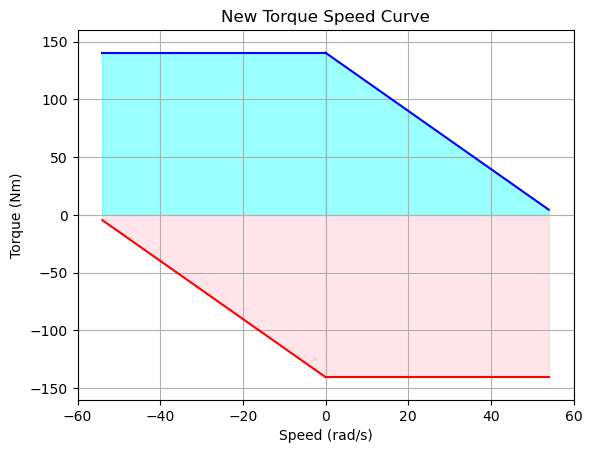

In [101]:
'''Plot Torque Speed Curve'''
import matplotlib.pyplot as plt
x_p = np.linspace(0, 54, num=54)
x_n = np.linspace(-54, 0, num=54)
no_load_speed = 55.8
# from graph
max_torque = 38.0
speed_max_torque = 40.7

m_grad = (max_torque-0.0)/(speed_max_torque-no_load_speed)

stall_torque = 0.0 - m_grad*no_load_speed

y_p = m_grad*x_p+stall_torque
y_n = m_grad*x_n-stall_torque

stall_torque_p = []
stall_torque_n = []
rated_torque_p = []
rated_torque_n = []

for ii in range(len(x_p)):
    stall_torque_p.append(stall_torque)
    stall_torque_n.append(-stall_torque)
    rated_torque_p.append(max_torque)
    rated_torque_n.append(-max_torque)

plt.grid()
plt.plot(x_p, y_p,'b')
plt.plot(x_n, stall_torque_p,'b')

plt.fill_between(x_p, y_p, alpha=0.4, color = 'cyan')
plt.fill_between(x_n, stall_torque_p, alpha=0.4,color = 'cyan')

plt.plot(x_n, y_n,'r')
plt.plot(x_p, stall_torque_n,'r')

plt.fill_between(x_n, y_n, alpha=0.4,color = 'pink')
plt.fill_between(x_p, stall_torque_n, alpha=0.4,color = 'pink')

plt.axis((-60,60,-160,160))
plt.title('New Torque Speed Curve')
plt.xlabel('Speed (rad/s)')
plt.ylabel('Torque (Nm)')
print('--------------')

print('Stall torque = ',stall_torque)
print('Max speed = ',no_load_speed)

print('--------------')

In [102]:
test = 'Torque_Test'
N = 60
TT = 0.6

In [103]:
m = ConcreteModel('Biped')

#SETS-------------------------
m.N = RangeSet(N)
m.ground_constraints = Set(initialize = ground_constraints)
m.legs = Set(initialize = legs)
m.links = Set(initialize = links)
m.bases = Set(initialize = bases)
m.all_links = Set(initialize = all_links)
m.leg_links = Set(initialize = leg_links)
m.all_links_inertia = Set(initialize = all_links_inertia)
m.DOFs = Set(initialize = DOFs)
m.WDOFs = Set(initialize = WDOFs)
m.signs = Set(initialize = signs)
m.sides = Set(initialize = sides)

#Params--------------------------
m.g = Param(initialize = 0.0)
m.BLD = Param(initialize = 60/1000)
m.foot_angle = Param(initialize = 135*(np.pi/180))
m.foot_length = Param(initialize = 42.5/1000)
m.cg = Param(initialize = 1.149)
m.lx_boom = Param(initialize = 2.575)
m.ly_boom = Param(initialize = 2.493)
m.y_boomOffset = Param(initialize = 0.101)
m.y_bodyOffset = Param(initialize = 8.36/1000)
m.x_footOffset = Param(initialize = 1.63/1000)

m.COMR = Param(m.leg_links, initialize = COMR_)
m.masses = Param(m.all_links, initialize = masses_)
m.lengths = Param(m.all_links, initialize = lengths_)
m.inertias = Param(m.all_links_inertia, initialize = inertias_)


#VARIABLES----------------------
#gen coordinates
m.q = Var(m.N,m.DOFs)
m.dq = Var(m.N,m.DOFs)
m.ddq = Var(m.N,m.DOFs)

''' CONSTRAINTS  - Integration'''
# variable timestep
hm = TT/N # master timestep
m.h = Var(m.N, bounds = (0.8,1.2)) #m.h = Var(m.N, bounds = (0.5,1.5))

def BwEuler_p(m,n,dof):
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip
m.integrate_p = Constraint(m.N, m.DOFs, rule = BwEuler_p)

def BwEuler_v(m,n,dof):
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOFs, rule = BwEuler_v)

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lengths) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from
    /home/mark/miniconda3/lib/python3.9/site-
    packages/pyomo/core/base/param.py:77)


In [104]:
''' CONSTRAINTS  - CONNECTION POINT'''
m.connect_position = Var(m.N, m.WDOFs, m.sides, m.legs) # connection point
m.connect_force = Var(m.N, m.WDOFs, m.legs,bounds = (-10*total_mass*9.81,10*total_mass*9.81)) # connection force

# Lamdify
lamb_connect_position = {} # (WDOFs,sides,leg)
[lamb_connect_position.update({(wdof,side,leg): sym.lambdify(sym_list,connect_position[side,leg][coordinates[wdof]],modules = [func_map])}) for leg in legs for side in sides for wdof in WDOFs]

# Equate the connection equations from the previous script to the model m
def def_connect_position_equation(m,n,wdof,side,leg):
    var_list = get_var_list_zeros(m,n)    
    return m.connect_position[n,wdof,side,leg] == lamb_connect_position[wdof,side,leg](*var_list)
m.connect_position_equation = Constraint(m.N, m.WDOFs, m.sides, m.legs, rule = def_connect_position_equation)

# Ensure that there is no distance between the X (and Y) of link connection points
def def_connect_position(m,n,wdof,leg):
    return  m.connect_position[n,wdof,'right',leg] - m.connect_position[n,wdof,'left',leg] == 0.0
m.connect_position_constraint = Constraint(m.N, m.WDOFs, m.legs, rule= def_connect_position)

In [105]:
#Variable of foot position
m.foot_position = Var(m.N, m.WDOFs, m.legs)
for n in range(1,N+1):
    for leg in legs:
        m.foot_position[n,'Y',leg].setlb(0.0)

#Get the foot position in WDOF
lamb_foot_position = {}
[lamb_foot_position.update({(wdof,leg): sym.lambdify(sym_list,foot_position['right',leg][coordinates[wdof]],modules = [func_map])}) for leg in legs for wdof in WDOFs]

def def_foot_position(m,n,wdof,leg):
    var_list = get_var_list_zeros(m,n)
    return m.foot_position[n,wdof,leg] == lamb_foot_position[wdof,leg](*var_list)
m.def_foot_position = Constraint(m.N, m.WDOFs, m.legs, rule = def_foot_position)

In [106]:
'''Torque Speed - Speed Torque Curve'''

m.tau_torque = Var(m.N, m.sides, m.legs, bounds = (-max_torque,max_torque))
m.tau_velocity = Var(m.N, m.sides, m.legs, bounds = (-no_load_speed,no_load_speed))

lamb_tau_velocity = {}
[lamb_tau_velocity.update({(side,leg): sym.lambdify(sym_list,w_links[motor_w_angle[side],leg],modules = [func_map])}) for leg in legs for side in sides]

def def_angular_velocity(m,n,side,leg):
    var_list = get_var_list_zeros(m,n)
    return m.tau_velocity[n,side,leg] == lamb_tau_velocity[side,leg](*var_list)
m.left_angular_velocity_constraint = Constraint(m.N, m.sides, m.legs, rule = def_angular_velocity)

# assume straight line
def def_TW_right(m,n,side,leg):
    return m.tau_torque[n,side,leg] <= m.tau_velocity[n,side,leg]*m_grad + stall_torque
m.TW_right_constraint = Constraint(m.N, m.sides, m.legs, rule = def_TW_right)

def def_TW_left(m,n,side,leg):
    return m.tau_torque[n,side,leg] >= m.tau_velocity[n,side,leg]*m_grad - stall_torque
m.TW_left_constraint = Constraint(m.N, m.sides, m.legs, rule = def_TW_left)



In [107]:
def def_max_change_torque(m,n,side,leg):
    if n<(N-1):
        return abs(m.tau_torque[n+1,side,leg] - m.tau_torque[n,side,leg]) <= 5 
    else:
        return abs(m.tau_torque[n,side,leg] - m.tau_torque[n-1,side,leg]) <= 5
m.max_change_torque = Constraint(m.N, m.sides, m.legs, rule = def_max_change_torque)

In [108]:
# Set the angles for the knees - only use this when actuated 
# This ensures links does not cross
m.knee_angle = Var(m.N, m.sides, m.legs, bounds = (0.0,140*(np.pi)/180))

def def_knee_angle(m,n,side,leg):
    if side == 'left':
        return m.knee_angle[n,side,leg] == 2*np.pi - m.q[n,'theta_LL'+leg]
    else:
        return m.knee_angle[n,side,leg] == m.q[n,'theta_LR'+leg]   
m.knee_angle_constraint = Constraint(m.N, m.sides, m.legs, rule = def_knee_angle)

In [109]:
#test code

sign_symbols = ['+','-']
boundaries = ['setub','setlb']

# for n in range(1,N+1):
#     for leg in legs:
#         for index in range(len(boundaries)):
#             eval('m.q[n,\'theta_UL\'+leg].{0}(np.pi*(0.5{1}1/1.5))'.format(boundaries[index],sign_symbols[index]))
#             eval('m.q[n,\'theta_LL\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))  
#             eval('m.q[n,\'theta_UR\'+leg].{0}(np.pi*(0.5{1}1/1.5))'.format(boundaries[index],sign_symbols[index]))    
#             eval('m.q[n,\'theta_LR\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))


for n in range(1,N+1):
    if test == 'High_Drop' or test == 'Low_Drop' or test == 'Drop_Hop' or test == 'Hop':
        x_low_lim = -1.0
        x_high_lim = 1.0
        y_low_lim = -0.5
        y_high_lim = 2.0
        
        if test == 'Drop_Hop' or test == 'Hop':
            [m.tau_torque[1,side,leg].fix(0.0) for side in sides for leg in legs]
        else:
            [m.tau_torque[n,side,leg].fix(0.0) for side in sides for leg in legs]
            
    else:
        x_low_lim = -1.0
        x_high_lim = 2.0
        y_low_lim = -0.5
        y_high_lim = 1.5
        
        if test == 'Sprint' or test == 'Periodic_Walk' or test == 'Periodic_Walk_Stop' or test == 'Start_Periodic_Walk':
            pass
        else:
            [m.tau_torque[1,side,leg].fix(0.0) for side in sides for leg in legs]
            
        

In [110]:

# m.foot_position[1, 'X', 'A'].fix(0.0)
# m.foot_position[1, 'X', 'B'].fix(0.0)

# for n in range(1,N+1):
#     m.foot_position[n, 'Y', 'A'].fix(0.6)
#     m.foot_position[n, 'Y', 'B'].fix(0.7)

m.foot_position[1,'X','A'].fix(0)
m.foot_position[1,'Y','A'].fix(0.7)
    
m.foot_position[1,'X','B'].fix(0)
m.foot_position[1,'Y','B'].fix(0.7)

m.foot_position[15,'X','A'].fix(0.1)
m.foot_position[15,'X','B'].fix(-0.1)


m.foot_position[30,'X','A'].fix(0)
m.foot_position[30,'Y','A'].setub(0.6)
    
m.foot_position[30,'X','B'].fix(0)
m.foot_position[30,'Y','B'].setub(0.6)
    
m.foot_position[45,'X','A'].fix(-0.1)
m.foot_position[45,'X','B'].fix(0.1)
    
m.foot_position[N,'X','A'].fix(0)
m.foot_position[N,'Y','A'].fix(0.7)
    
m.foot_position[N,'X','B'].fix(0)
m.foot_position[N,'Y','B'].fix(0.7)

In [111]:
# COST FUNCTION -------------------------------------------------------------------------------------------------------------
def CostFun(m):
    row = 1e4 # scale the penalty
    tau_sum = 0.0
    pen_sum = 0.0
    transport_sum = 0.0
    tau_diff = 0.0
   
    
    T = sum(m.h[n] for n in range(1,N+1))
    
    for n in range(1,N+1):
        for leg in legs:
            for side in sides:
                tau_sum += (m.tau_torque[n,side,leg])**2
#                 tau_diff = sum(diff(m.tau_torque[n,side,leg]))
#                 if n<N:
#                     tau_diff += (m.tau_torque[n+1,side,leg] - m.tau_torque[n,side,leg])**2
                

    return tau_sum #+ tau_diff
m.Cost = Objective(rule = CostFun)

In [112]:
''' Turning EOM back to pyomo (from sympy) '''
#create the constraints


def EOM_th_ULA(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_ULA'](*var_list) == 0
m.EOM_th_ULA_constraint = Constraint(m.N, rule = EOM_th_ULA)

def EOM_th_LLA(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_LLA'](*var_list) == 0
m.EOM_th_LLA_constraint = Constraint(m.N, rule = EOM_th_LLA)

def EOM_th_URA(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['theta_URA'](*var_list) == 0
m.EOM_th_URA_constraint = Constraint(m.N, rule = EOM_th_URA)

def EOM_th_LRA(m,n):
    var_list = get_var_list_values(m,n)    
    return lamb_EOMs['theta_LRA'](*var_list) == 0
m.EOM_th_LRA_constraint = Constraint(m.N, rule = EOM_th_LRA)

def EOM_th_ULB(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_ULB'](*var_list) == 0
m.EOM_th_ULB_constraint = Constraint(m.N, rule = EOM_th_ULB)

def EOM_th_LLB(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_LLB'](*var_list) == 0
m.EOM_th_LLB_constraint = Constraint(m.N, rule = EOM_th_LLB)

def EOM_th_URB(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['theta_URB'](*var_list) == 0
m.EOM_th_URB_constraint = Constraint(m.N, rule = EOM_th_URB)

def EOM_th_LRB(m,n):
    var_list = get_var_list_values(m,n)    
    return lamb_EOMs['theta_LRB'](*var_list) == 0
m.EOM_th_LRB_constraint = Constraint(m.N, rule = EOM_th_LRB)

In [113]:
# solving
#opt = SolverFactory('ipopt',executable = '/home/uct/Trajectory_Optimization/IPOPT/build/bin/ipopt')
opt = SolverFactory('ipopt')
opt.options["linear_solver"] = 'ma86'

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
#pt.options["linear_system_scaling"] = 'none'
#opt.options["mu_strategy"] = "adaptive"
opt.options["print_level"] = 5     # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000*20   # maximum number of iterations
opt.options["max_cpu_time"] = 600*20 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6          # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.

results = opt.solve(m, tee = True)

# model.piston_complementarity.deactivate()
# result = default_solver('/usr/local/bin/ipopt', approximate_hessian=False).solve(model, tee=True)
# if result.solver.termination_condition != TerminationCondition.optimal: quit()
# # solve for discrete piston control3
# model.piston_complementarity.activate()
# result = default_solver('/usr/local/bin/ipopt', approximate_hessian=False, warm_start=True).solve(model, tee=True)

Ipopt 3.14.10: linear_solver=ma86
expect_infeasible_problem=yes
print_level=5
max_iter=600000
max_cpu_time=12000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.10, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    11198
Number of nonzeros in inequality constraint Jacobian.:     1428
Number of nonzeros in Lagrangian Hessian.............:     4772

Total number of variables............................:     3161
                     variables with only lower bounds:      114
                variables with lower and upper bounds:     1017
                     variables with onl

In [114]:
print(results.solver.termination_condition) # check if optimal

optimal


In [115]:
# tau_sum = 0.0
# for n in range(1,N+1):
#     for leg in legs:
#         for side in sides:
#             tau_sum += (m.tau_torque[n,side,leg])**2
# print(tau_sum)

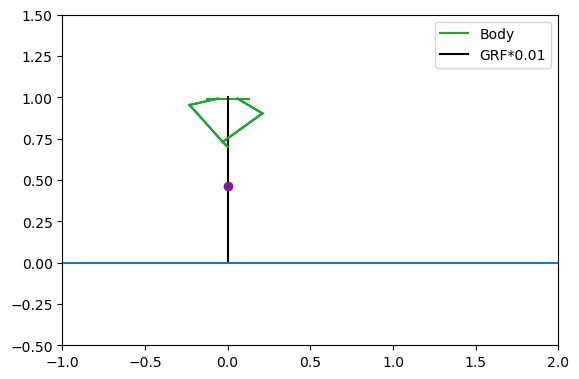

In [116]:
#animate it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

# arrays to store values
N_time = []

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([x_low_lim,x_high_lim])
    ax.set_ylim([y_low_lim,y_high_lim])
    N_time.append(i)
     
    plot_body = {}
    plot_boom = {}
    plot_boom_COM = {}
    plot_UR = {}
    plot_LR = {}
    plot_UL = {}
    plot_LL = {}
    plot_foot = {}
    abs_angles = {}
    bod_angle = 0
    
    # plot body
    plot_body.update({('x_back'):0 - 0.5*m.lengths['body']*cos(bod_angle)})
    plot_body.update({('y_back'):1 - m.y_bodyOffset.value - 0.5*m.lengths['body']*sin(bod_angle)})
    plot_body.update({('x_front'):0 + 0.5*m.lengths['body']*cos(bod_angle)})
    plot_body.update({('y_front'):1 - m.y_bodyOffset.value + 0.5*m.lengths['body']*sin(bod_angle)})  
    ax.plot([plot_body['x_back'],plot_body['x_front']],[plot_body['y_back'],plot_body['y_front']],color='xkcd:green')
    
    # plot boom
    plot_boom.update({('x_back'): 0.0})
    plot_boom.update({('y_back'): m.y_bodyOffset.value})
    plot_boom.update({('x_front'):0 })
    plot_boom.update({('y_front'):1 })  
    ax.plot([plot_boom['x_back'],plot_boom['x_front']],[plot_boom['y_back'],plot_boom['y_front']],color='xkcd:black')

    # plot boom COM
    plot_boom_COM.update({('x'): (m.cg.value/m.lx_boom.value)*0})
    plot_boom_COM.update({('y'): (m.cg.value/m.ly_boom.value)*1})
    ax.plot([plot_boom_COM['x']],[plot_boom_COM['y']],color='xkcd:purple',marker="o")

    for leg in legs:
        if leg == 'A':
            link_colour = ['blue','red']
        else:
            link_colour = ['green','purple']
        
        
        #plot upper right
        abs_angles.update({('RU',leg): bod_angle + m.q[i,'theta_UR'+leg].value})
        plot_UR.update({('top','X',leg): 0 + m.BLD.value*cos(bod_angle)})
        plot_UR.update({('top','Y',leg): 1 - m.y_bodyOffset.value + m.BLD.value*sin(bod_angle)})
        plot_UR.update({('bot','X',leg): plot_UR['top','X',leg] - m.lengths['UR'+leg]*cos(abs_angles['RU',leg])})
        plot_UR.update({('bot','Y',leg): plot_UR['top','Y',leg] - m.lengths['UR'+leg]*sin(abs_angles['RU',leg])})
        ax.plot([plot_UR['top','X',leg],plot_UR['bot','X',leg]],[plot_UR['top','Y',leg],plot_UR['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))
        
        #plot lower right
        abs_angles.update({('RL',leg): m.q[i,'theta_LR'+leg].value - (np.pi-abs_angles['RU',leg])})
        plot_LR.update({('top','X',leg): plot_UR['bot','X',leg]})
        plot_LR.update({('top','Y',leg): plot_UR['bot','Y',leg]})
        plot_LR.update({('bot','X',leg): plot_UR['bot','X',leg] - m.lengths['LR'+leg]*cos(abs_angles['RL',leg])})
        plot_LR.update({('bot','Y',leg): plot_UR['bot','Y',leg] - m.lengths['LR'+leg]*sin(abs_angles['RL',leg])})
        ax.plot([plot_LR['top','X',leg],plot_LR['bot','X',leg]],[plot_LR['top','Y',leg],plot_LR['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))
        
        #plot foot
        plot_foot.update({('top','X',leg): plot_LR['bot','X',leg]})
        plot_foot.update({('top','Y',leg): plot_LR['bot','Y',leg]})
        plot_foot.update({('bot','X',leg): plot_LR['bot','X',leg] + m.foot_length.value*cos(m.foot_angle.value - (np.pi)/2)})
        plot_foot.update({('bot','Y',leg): plot_LR['bot','Y',leg] - m.foot_length.value*sin(m.foot_angle.value - (np.pi)/2)})
        ax.plot([plot_foot['top','X',leg],plot_foot['bot','X',leg]],[plot_foot['top','Y',leg],plot_foot['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

        #plot upper left
        abs_angles.update({('LU',leg): bod_angle + m.q[i,'theta_UL'+leg].value})
        plot_UL.update({('top','X',leg): 0 - m.BLD.value*cos(bod_angle)})
        plot_UL.update({('top','Y',leg): 1 - m.y_bodyOffset.value - m.BLD.value*sin(bod_angle)})
        plot_UL.update({('bot','X',leg): plot_UL['top','X',leg] - m.lengths['UL'+leg]*cos(abs_angles['LU',leg])})
        plot_UL.update({('bot','Y',leg): plot_UL['top','Y',leg]- m.lengths['UL'+leg]*sin(abs_angles['LU',leg])})
        ax.plot([plot_UL['top','X',leg],plot_UL['bot','X',leg]],[plot_UL['top','Y',leg],plot_UL['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

        #plot lower left
        abs_angles.update({('LL',leg):m.q[i,'theta_LL'+leg].value - (np.pi-abs_angles['LU',leg])})
        plot_LL.update({('top','X',leg): plot_UL['bot','X',leg]})
        plot_LL.update({('top','Y',leg): plot_UL['bot','Y',leg]})
        plot_LL.update({('bot','X',leg): plot_UL['bot','X',leg] - m.lengths['LL'+leg]*cos(abs_angles['LL',leg])})
        plot_LL.update({('bot','Y',leg): plot_UL['bot','Y',leg] - m.lengths['LL'+leg]*sin(abs_angles['LL',leg])})
        ax.plot([plot_LL['top','X',leg],plot_LL['bot','X',leg]],[plot_LL['top','Y',leg],plot_LL['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))     
    
 

    
    ax.legend(["Body","GRF*0.01"], frameon=True)
    
    ax.plot([-10,10],[0,0]) # plot the ground
    
    
update = lambda i: plot_robot(i,m,ax1) # lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


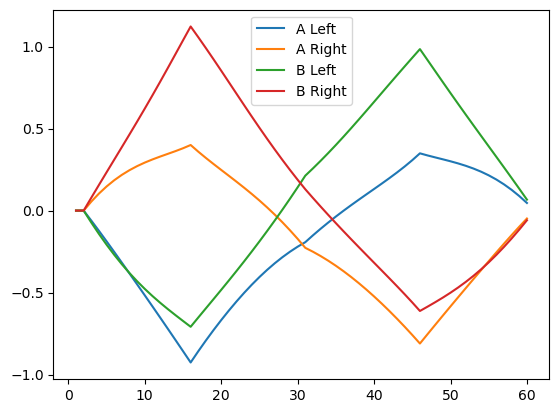

In [117]:
x = np.arange(1,61,1)
LeftA = []
RightA = []
LeftB = []
RightB = []

for n in range(1,N+1):
    LeftA.append(m.tau_torque[n,'left','A'].value)
    RightA.append(m.tau_torque[n,'right','A'].value)
    LeftB.append(m.tau_torque[n,'left','B'].value)
    RightB.append(m.tau_torque[n,'right','B'].value)
    
line1 = plt.plot(x,LeftA,label = 'A Left')
line2 = plt.plot(x,LeftB,label = 'A Right')
line3 = plt.plot(x,RightA,label = 'B Left')
line4 = plt.plot(x,RightB,label = 'B Right')
plt.legend()

In [144]:
m.tau_torque[5,'left','A'].value

-0.18723857983241957

In [147]:
m.q[1,'theta_ULA'].value

-12.345799144241422

In [118]:
# # abs(m.tau_torque[25,'right','B'].value-m.tau_torque[24,'right','B'].value)#<=10
# for n in range(1,N+1):
#     if n<N:
#         print(abs(m.tau_torque[n+1,'right','B'].value-m.tau_torque[n,'right','B'].value))
    
# # np.diff(m.tau_torque[n,'left','A'] for n in range(1,N+1)) 

In [125]:
print(['leftA','rightA','leftB','rightB'])
for n in range(1,N+1):
    print(m.tau_torque[n,'left','A'].value,m.tau_torque[n,'right','A'].value,m.tau_torque[n,'left','B'].value,m.tau_torque[n,'right','B'].value)
    
    

['leftA', 'rightA', 'leftB', 'rightB']
0.0 0.0 0.0 0.0
-1.5372283633353351e-10 -1.5507669140968098e-10 1.0236941230284517e-10 1.92508255379613e-10
-0.06088453370839028 -0.0728875780745018 0.054932097870932825 0.0787191280550894
-0.12342582470560425 -0.1422501860895296 0.10390863116143448 0.1565653815523342
-0.18723857983241957 -0.20784660683640313 0.14717498180042082 0.23376990141104356
-0.2520036764470313 -0.2695181517573444 0.18507746803802 0.3106405179461697
-0.3174761225597158 -0.3272066301865624 0.21805172104138135 0.3875392107602565
-0.3834848305466469 -0.3809638971503406 0.24661123449324335 0.46485500764806886
-0.4499258176025719 -0.43095329291489026 0.27133868160683217 0.5429715495264261
-0.5167505205458818 -0.47744427001460127 0.2928813844210778 0.6222281376795421
-0.5839507924190755 -0.5208020579785092 0.3119510426134382 0.7028733852804873
-0.6515419461321359 -0.5614743126825843 0.32932662047642314 0.7850120718442989
-0.7195450004947699 -0.5999764182288859 0.3458583158323794 

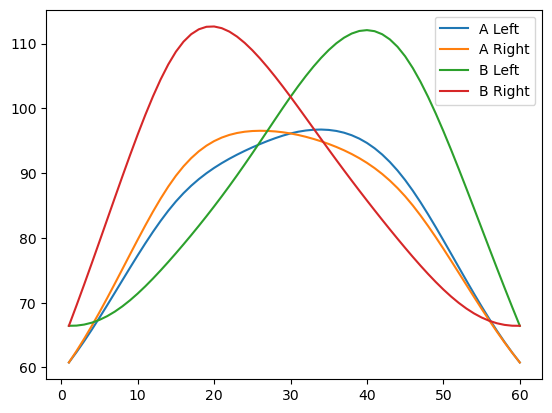

In [126]:
x = np.arange(1,N+1,1)
LeftA = []
RightA = []
LeftB = []
RightB = []

for n in range(1,N+1):
    LeftA.append(m.knee_angle[n,'left','A'].value*180/np.pi)
    RightA.append(m.knee_angle[n,'right','A'].value*180/np.pi)
    LeftB.append(m.knee_angle[n,'left','B'].value*180/np.pi)
    RightB.append(m.knee_angle[n,'right','B'].value*180/np.pi)
    
line1 = plt.plot(x,LeftA,label = 'A Left')
line2 = plt.plot(x,LeftB,label = 'A Right')
line3 = plt.plot(x,RightA,label = 'B Left')
line4 = plt.plot(x,RightB,label = 'B Right')
plt.legend()

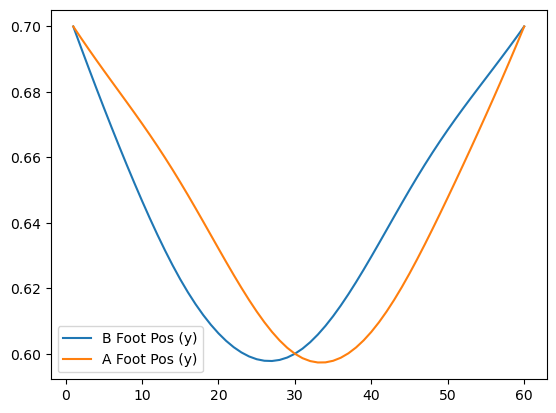

In [121]:
x = np.arange(1,N+1,1)

bGRFy = []
bFootPos = []
aGRFy = []
aFootPos = []
footScale = 1

for n in range(1,N+1):
#     bGRFy.append(m.GRF_y[n,'B'].value)
    bFootPos.append(m.foot_position[n,'Y','B'].value*footScale)
#     aGRFy.append(m.GRF_y[n,'A'].value)
    aFootPos.append(m.foot_position[n,'Y','A'].value*footScale)

# bGRFyline = plt.plot(x,bGRFy,label = 'B GRFy')
bFootline = plt.plot(x,bFootPos,label = 'B Foot Pos (y)')
# aGRFyline = plt.plot(x,aGRFy,label = 'A GRFy')
aFootline = plt.plot(x,aFootPos,label = 'A Foot Pos (y)')
plt.legend()

In [122]:
# for n in range(1,N+1):
#     print(m.GRF_y[n,'B'].value,m.foot_position[n,'X','B'].value,m.q[n,'y_body'].value)
# # m.dq[N,'x_body'].value

In [123]:
# guide

In [132]:
for n in range(1,N+1):
    print(m.q[n,'theta_URA'].value+2*np.pi)
#m.foot_position[2,'X','B'].value

2.6049134072246334
2.6444153124757315
2.681574153826649
2.7157801403199575
2.7465103890972173
2.773333311841733
2.795908401928379
2.81398148936631
2.827375955109195
2.83598068237066
2.8397356494802577
2.8386160545677313
2.832615750811533
2.821730615575856
2.8059423267301957
2.785202911206804
2.760049820830303
2.7309576872828583
2.6983547673563915
2.6626367525426904
2.624178125279472
2.5833413528136044
2.54048427921077
2.4959661132324533
2.450152415604755
2.403419461631599
2.356158290846502
2.3087786508189123
2.2617128943825895
2.215419698137465
2.170387241817047
2.1269000700911667
2.0852701322075644
2.045836759550962
2.0089654063892013
1.9750448347149243
1.944482499355578
1.9176980762460483
1.8951153839303725
1.8771533487863294
1.864217085010492
1.856690489613353
1.8549318722724628
1.8592739726893495
1.8700292695798293
1.887500851606167
1.9111661284497803
1.9405311963442236
1.9751421181219788
2.0145894492153094
2.058507117665661
2.106566935634925
2.1584699247049652
2.21393543364334
2.2

In [129]:
thULA = []
thURA = []
thULB = []
thURB = []
dthULA = []
dthURA = []
dthULB = []
dthURB = []
LeftA = []
RightA = []
LeftB = []
RightB = []

for n in range(1,N+1):
    thULA.append(m.q[n,'theta_ULA'].value)
    thURA.append(m.q[n,'theta_URA'].value)
    thULB.append(m.q[n,'theta_ULB'].value)
    thURB.append(m.q[n,'theta_URB'].value)
    dthULA.append(m.dq[n,'theta_ULA'].value)
    dthURA.append(m.dq[n,'theta_URA'].value)
    dthULB.append(m.dq[n,'theta_ULB'].value)
    dthURB.append(m.dq[n,'theta_URB'].value)
    LeftA.append(m.tau_torque[n,'left','A'].value)
    RightA.append(m.tau_torque[n,'right','A'].value)
    LeftB.append(m.tau_torque[n,'left','B'].value)
    RightB.append(m.tau_torque[n,'right','B'].value)
    
#     print(m.q[n,'theta_ULA'].value)
# position_data = {'thULA':thULA,'thURA':thURA,'thULB':thULB,'thURB':thURB}
# with open('position_data_test1.pkl','wb') as f:
#     pickle.dump(position_data, f)
# print(position_data['thULA'])
heading0 = ['node']
heading1 = ['thULA','thURA','thULB','thURB','dthULA','dthURA','dthULB','dthURB','tLeftA','tRightA','tLeftB','tRightB']
heading = heading0+heading1
import csv
with open('torque_test4.csv','w') as f:
    writer = csv.writer(f)
    writer.writerow(heading)
    for n in range(N):
        node = [n]
        data1 = [thULA[n],thURA[n],thULB[n],thURB[n],dthULA[n],dthURA[n],dthULB[n],dthURB[n],LeftA[n],RightA[n],LeftB[n],RightB[n]]
        data = node+data1
        writer.writerow(data)



In [ ]:
TT


In [ ]:
# m.dq[1,'theta_URA'].value

In [ ]:
# for n in range(1,N+1):
#     print(m.q[n,'y_body'].value)


In [ ]:
#m.dq[N,'y_body'].value
V_avg

<!-- 1.4=72cm
x=45cm -->

In [ ]:
# m.foot_position[N,'Y','B'].value

In [ ]:
# save1 = False
# if save1 == True:
#     data =  {'ybod' : m.q[N,'y_body'].value,
#         'dxbod' : m.dq[N,'x_body'].value,
#         'dthULA' : m.dq[N,'theta_ULA'].value,
#         'dthLLA' : m.dq[N,'theta_LLA'].value,
#         'dthURA' : m.dq[N,'theta_URA'].value,
#         'dthLRA' : m.dq[N,'theta_LRA'].value,

#         'dthULB' : m.dq[N,'theta_ULB'].value,
#         'dthLLB' : m.dq[N,'theta_LLB'].value,
#         'dthURB' : m.dq[N,'theta_URB'].value,
#         'dthLRB' : m.dq[N,'theta_LRB'].value}
#     with open('periodic_walk_start_v7.pkl', 'wb') as f: 
#         pickle.dump(data, f)



In [ ]:
save2 = False
if save2 == True:
    data =  {'ybod' : m.q[1,'y_body'].value,
             'dybod' : m.dq[1,'y_body'].value,
        'dxbod' : m.dq[1,'x_body'].value,
             
        'thULA' : m.q[1,'theta_ULA'].value,
        'thLLA' : m.q[1,'theta_LLA'].value,
        'thURA' : m.q[1,'theta_URA'].value,
        'thLRA' : m.q[1,'theta_LRA'].value,

        'thULB' : m.q[1,'theta_ULB'].value,
        'thLLB' : m.q[1,'theta_LLB'].value,
        'thURB' : m.q[1,'theta_URB'].value,
        'thLRB' : m.q[1,'theta_LRB'].value,
             
             
        'dthULA' : m.dq[1,'theta_ULA'].value,
        'dthLLA' : m.dq[1,'theta_LLA'].value,
        'dthURA' : m.dq[1,'theta_URA'].value,
        'dthLRA' : m.dq[1,'theta_LRA'].value,

        'dthULB' : m.dq[1,'theta_ULB'].value,
        'dthLLB' : m.dq[1,'theta_LLB'].value,
        'dthURB' : m.dq[1,'theta_URB'].value,
        'dthLRB' : m.dq[1,'theta_LRB'].value}
    with open('periodic_walk_N1_data_v10.pkl', 'wb') as f: 
        pickle.dump(data, f)



In [ ]:
save2 = False
if save2 == True:
    data =  {'ybod' : m.q[N,'y_body'].value,
             'dybod' : m.dq[N,'y_body'].value,
        'dxbod' : m.dq[N,'x_body'].value,
             
        'thULA' : m.q[N,'theta_ULA'].value,
        'thLLA' : m.q[N,'theta_LLA'].value,
        'thURA' : m.q[N,'theta_URA'].value,
        'thLRA' : m.q[N,'theta_LRA'].value,

        'thULB' : m.q[N,'theta_ULB'].value,
        'thLLB' : m.q[N,'theta_LLB'].value,
        'thURB' : m.q[N,'theta_URB'].value,
        'thLRB' : m.q[N,'theta_LRB'].value,
             
             
        'dthULA' : m.dq[N,'theta_ULA'].value,
        'dthLLA' : m.dq[N,'theta_LLA'].value,
        'dthURA' : m.dq[N,'theta_URA'].value,
        'dthLRA' : m.dq[N,'theta_LRA'].value,

        'dthULB' : m.dq[N,'theta_ULB'].value,
        'dthLLB' : m.dq[N,'theta_LLB'].value,
        'dthURB' : m.dq[N,'theta_URB'].value,
        'dthLRB' : m.dq[N,'theta_LRB'].value}
    with open('periodic_walk_finalN_data_v10.pkl', 'wb') as f: 
        pickle.dump(data, f)

In [ ]:
# for n in range(1,N+1):
#     print(m.knee_angle[n,'left','B'].value*180/np.pi)


In [ ]:
# with open('periodic_walk_start_v.pkl','rb') as f:
#     start = pickle.load(f)
# start

In [ ]:
# start[0]['xbod']
